## Brouillon Diane

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### Données BNP min par min, trop high frequency pour notre analyse

In [2]:
bnp = pd.read_excel('dataset_Prices/BNP_Prices.xlsx')

In [3]:
bnp.head()

,BNP FP Equity,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Dates,Open,Close,High,Low
1,2022-09-13 09:00:00.005000,50.8,50.84,50.91,50.75
2,2022-09-13 09:01:00,50.86,50.91,50.91,50.85
3,2022-09-13 09:02:00,50.87,50.87,50.9,50.84
4,2022-09-13 09:03:00,50.88,50.86,50.91,50.82


### Daily returns JPM et SP500

In [4]:
start_date = '2005-01-01'
end_date = '2023-12-31'

data_JPM = yf.download(tickers="JPM", start=start_date, end=end_date)

C:\Users\diane\AppData\Local\Temp\ipykernel_10736\1991613486.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_JPM = yf.download(tickers="JPM", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [5]:
data_SP500 = yf.download(tickers="^GSPC", start=start_date, end=end_date)
print("data_SP500 shape : ", data_SP500.shape)
data_SP500.tail()


C:\Users\diane\AppData\Local\Temp\ipykernel_10736\2591821409.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_SP500 = yf.download(tickers="^GSPC", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

data_SP500 shape :  (4781, 5)


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000
2023-12-27,4781.580078,4785.390137,4768.899902,4773.450195,2748450000
2023-12-28,4783.350098,4793.299805,4780.979980,4786.439941,2698860000
2023-12-29,4769.830078,4788.430176,4751.990234,4782.879883,3126060000


In [6]:
dates = np.array(data_SP500.index)
values = np.array(data_SP500['Close'])

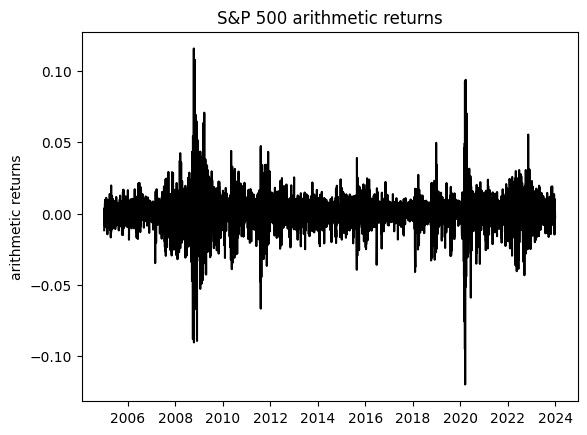

In [7]:
arithmetic_returns_aux = (values[1:] - values[0:-1]) / values[0:-1]
arithmetic_returns=arithmetic_returns_aux.flatten() #from a 2D array (n,1) in a 1D array
return_dates = dates[1:]

plt.plot(return_dates, arithmetic_returns, color='k')
plt.title("S&P 500 arithmetic returns")
plt.ylabel("arithmetic returns")
plt.show()

In [8]:
r = arithmetic_returns - np.mean(arithmetic_returns)      # centrage

# choix du lag avec AIC
aic_vals = []
p_max = 10
for p in range(1, p_max+1):
    model = sm.tsa.ARIMA(r, order=(p,0,0)).fit()
    aic_vals.append(model.aic)

p_opt = np.argmin(aic_vals) + 1
print("p optimal =", p_opt)

# fit le modèle ar(p)
model_ar = sm.tsa.ARIMA(r, order=(p_opt,0,0)).fit()
print(model_ar.summary())

# prediction 1 step ahead
forecast = model_ar.forecast(steps=1)
print("Prévision AR(1-step) :", forecast[0])

c:\Users\diane\time-series-pred\tspenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p optimal = 9
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4780
Model:                 ARIMA(9, 0, 0)   Log Likelihood               14319.477
Date:                Mon, 12 Jan 2026   AIC                         -28616.954
Time:                        15:09:01   BIC                         -28545.760
Sample:                             0   HQIC                        -28591.944
                               - 4780                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.965e-06      0.000     -0.018      0.986      -0.000       0.000
ar.L1         -0.1252      0.007    -16.974      0.000      -0.140      -0.111
ar.L2         -0.0201      0.006     -

### Apple prediction

#### Acquisition des données et FE

In [22]:
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2024-12-31"

df_aapl = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=False
)

df_aapl = df_aapl[["Close"]].copy()
df_aapl["log_return"] = np.log(df_aapl["Close"] / df_aapl["Close"].shift(1))

# we delete the NAN created by the shift IN THE log returns
df_aapl.dropna(inplace=True) 

# Outlier handling (meilleure pred de 0.0001 MSE avec ça)
#lower, upper = df_aapl["log_return"].quantile([0.01, 0.99])
#df_aapl["log_return"] = df_aapl["log_return"].clip(lower, upper)

# Feature engineering
# Lagged returns (autoregressive structure)
for lag in range(1,11):
    df_aapl[f"ret_lag_{lag}"] = df_aapl["log_return"].shift(lag)

################
# AJOUT DE FEATURES SUPPLEMENTAIRES

# Rolling volatility
df_aapl["vol_20"] = df_aapl["log_return"].rolling(20).std()
df_aapl["vol_60"] = df_aapl["log_return"].rolling(60).std()     

# MACD
exp1 = df_aapl["Close"].ewm(span=12, adjust=False).mean()
exp2 = df_aapl["Close"].ewm(span=26, adjust=False).mean()
df_aapl["MACD"] = exp1 - exp2

# RSI
delta = df_aapl["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_aapl["RSI"] = 100 - (100 / (1 + rs))

##########################

# Drop rows with NaN from lags / rolling windows
df_aapl.dropna(inplace=True)

y = df_aapl["log_return"] # target : next-day log return
X = df_aapl.drop(columns=["Close", "log_return"]) # drop price & target, pour faire la matrice X de feature

print(X.head())
print(y.describe())

Price      ret_lag_1 ret_lag_2 ret_lag_3 ret_lag_4 ret_lag_5 ret_lag_6  \
Ticker                                                                   
Date                                                                     
2010-03-31  0.014779  0.006432  0.018578 -0.011930  0.004413  0.015935   
2010-04-01 -0.003610  0.014779  0.006432  0.018578 -0.011930  0.004413   
2010-04-05  0.004119 -0.003610  0.014779  0.006432  0.018578 -0.011930   
2010-04-06  0.010623  0.004119 -0.003610  0.014779  0.006432  0.018578   
2010-04-07  0.004393  0.010623  0.004119 -0.003610  0.014779  0.006432   

Price      ret_lag_7 ret_lag_8 ret_lag_9 ret_lag_10    vol_20    vol_60  \
Ticker                                                                    
Date                                                                      
2010-03-31  0.011186 -0.010741  0.002362  -0.001471  0.011924  0.017348   
2010-04-01  0.015935  0.011186 -0.010741   0.002362  0.011928  0.017351   
2010-04-05  0.004413  0.015935  

#### EDA

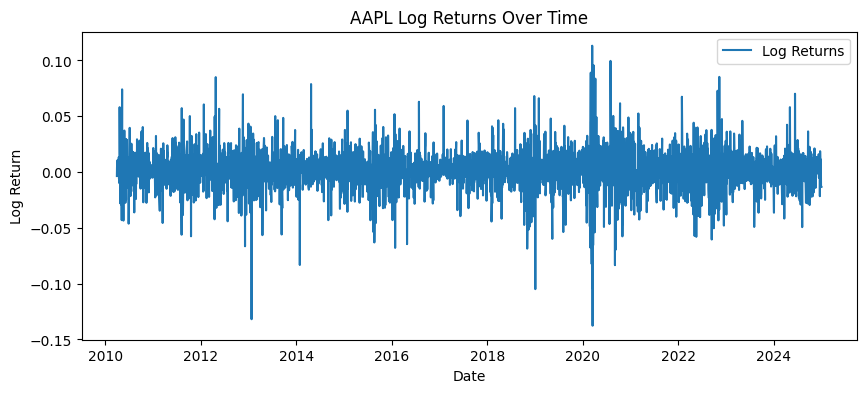

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(df_aapl.index, df_aapl["log_return"], label="Log Returns")
plt.title("AAPL Log Returns Over Time") 
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

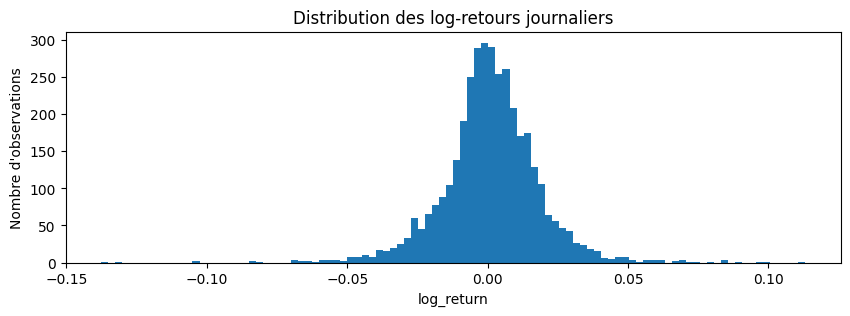

In [24]:
df_aapl["log_return"].hist(bins=100, figsize=(10, 3))
plt.title("Distribution des log-retours journaliers")
plt.xlabel("log_return")
plt.ylabel("Nombre d'observations")
plt.grid(False)
plt.show()


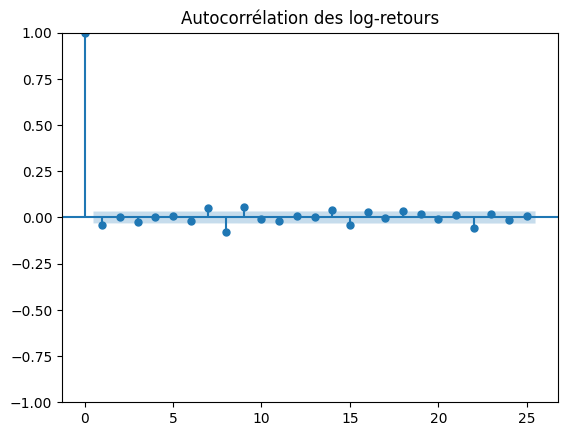

In [25]:
plot_acf(df_aapl["log_return"], lags=25)
plt.title("Autocorrélation des log-retours")
plt.show()


#### AR 1, 2, 5, 10

In [26]:
for p in [1, 2, 5, 10]:
    features = [f"ret_lag_{i}" for i in range(1, p + 1)]
    X_all = df_aapl[features].values
    y_all = df_aapl["log_return"].values

    # Paramètres de la walk-forward CV
    test_size = 50
    fold_size = 200
    step = test_size

    predictions = []
    truths = []

    # WFCV :
    for start in range(0, len(X_all) - fold_size - test_size, step):
        train_X = X_all[start : start + fold_size]
        train_y = y_all[start : start + fold_size]
        test_X = X_all[start + fold_size : start + fold_size + test_size]
        test_y = y_all[start + fold_size : start + fold_size + test_size]

        # OLS
        beta = np.linalg.pinv(train_X) @ train_y
        y_pred = test_X @ beta

        predictions.extend(y_pred)
        truths.extend(test_y)

    # MSE cross validee
    error = np.mean((np.array(predictions) - np.array(truths)) ** 2)
    print(f"AR({p}) - MSE: {error:.6f}")


AR(1) - MSE: 0.000314
AR(2) - MSE: 0.000315
AR(5) - MSE: 0.000320
AR(10) - MSE: 0.000325


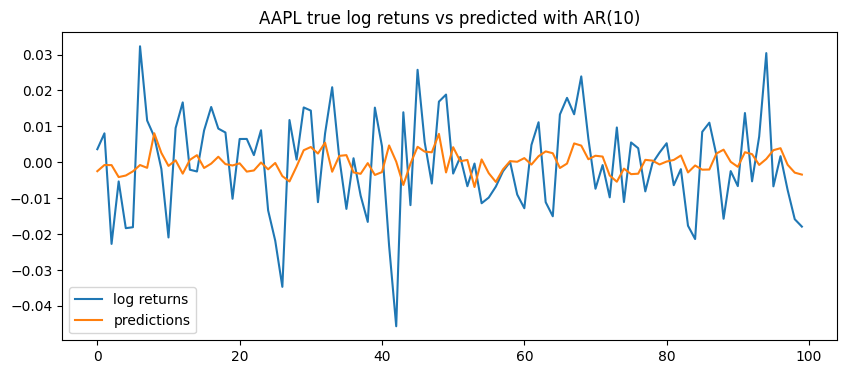

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(truths[:100], label="log returns")
plt.plot(predictions[:100], label="predictions")
plt.title("AAPL true log retuns vs predicted with AR(10)")
plt.legend()
plt.show()

#### RF 

RF ne voit pas la données chronologiquement. Pour ne pas violer la strucutre temporelle, il faut être vigilant à entrainer un modèle seulement sur les retours passés puis le tester sur le futur. 

A faire : parameter tuning sur le modèle

In [28]:
lags = list(range(1, 11))
features = [f"ret_lag_{i}" for i in lags]
X_all = df_aapl[features].values
y_all = df_aapl["log_return"].values

test_size = 50
fold_size = 200
step = test_size

mse_scores = []

for start in range(0, len(X_all) - fold_size - test_size, step):
    X_train = X_all[start : start + fold_size]
    y_train = y_all[start : start + fold_size]
    X_test = X_all[start + fold_size : start + fold_size + test_size]
    y_test = y_all[start + fold_size : start + fold_size + test_size]

    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

print(f"MSE moyenne sur les folds : {np.mean(mse_scores):.6f}")


MSE moyenne sur les folds : 0.000341


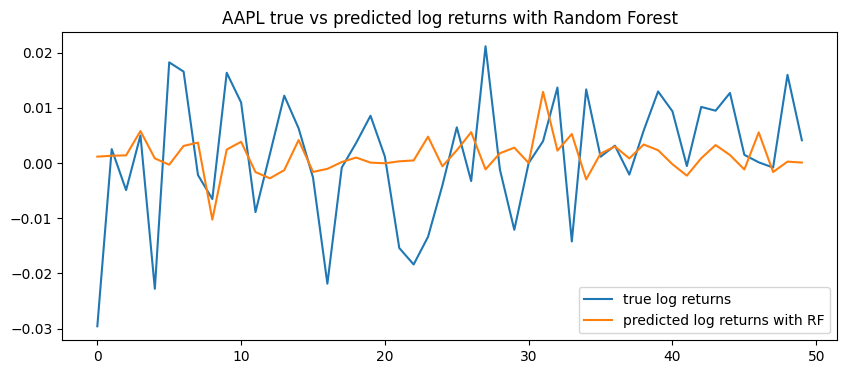

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(y_test, label="true log returns")
plt.plot(y_pred, label="predicted log returns with RF")
plt.title("AAPL true vs predicted log returns with Random Forest")
plt.legend()   
plt.show()

#### ResNet

CNN 1D, attention ce modèle est une ébauche, lors de la convolution je pense qu'il voit le futur, et le pooling enlève la temporalité. pas adapté à une time series. essayé plutôt un TCN ou une architecture spéciale de la littérature.

In [17]:
# Reshape pour CNN 1D : (samples, sequence_length, channels)
X_all = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)
y_all = y_all.reshape(-1, 1) # pr la compatibilité avec la mse

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + residual)

class ResNet1D(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=16, num_blocks=3):
        super().__init__()
        self.input_conv = nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_channels) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(hidden_channels, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channel, seq)
        x = self.input_conv(x)
        x = self.res_blocks(x)
        x = x.mean(dim=2)  # Global average pooling over time
        return self.output_layer(x)


In [19]:
#Paramètres de la CV
fold_size = 200
test_size = 50
step = test_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mse_scores = []

for start in range(0, len(X_all) - fold_size - test_size, step):
    end_train = start + fold_size
    start_test = end_train
    end_test = start_test + test_size

    # on extrait les plis de la CV
    X_train = torch.tensor(X_all[start:end_train], dtype=torch.float32)
    y_train = torch.tensor(y_all[start:end_train], dtype=torch.float32)
    X_test = torch.tensor(X_all[start_test:end_test], dtype=torch.float32)
    y_test = torch.tensor(y_all[start_test:end_test], dtype=torch.float32)

    # DataLoader
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)

    model = ResNet1D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    losses_per_epoch = [] # for plot

    # Entraînement simple (5 epochs)
    model.train()
    for epoch in range(10):
        batch_losses = []  # pour stocker les losses de chaque batch pr le plot à la fin essentiellement
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            #xb = xb.unsqueeze(-1)
            #yb = yb.unsqueeze(-1)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
    
        epoch_loss = np.mean(batch_losses)
        losses_per_epoch.append(epoch_loss)

    # eval
    model.eval()
    with torch.no_grad():
        preds = model(X_test.to(device)).cpu().numpy().flatten()
        truths = y_test.numpy().flatten()
        mse = np.mean((preds - truths) ** 2)
        mse_scores.append(mse)

print(f"MSE moyenne (ResNet) : {np.mean(mse_scores):.6f}")


MSE moyenne (ResNet) : 0.000316


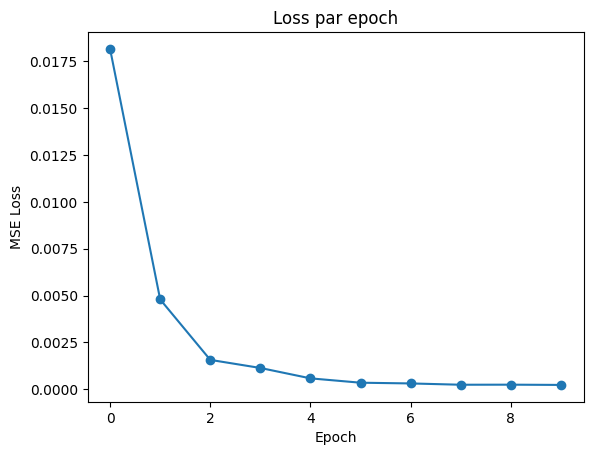

In [20]:
plt.plot(losses_per_epoch, marker='o')
plt.title("Loss par epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

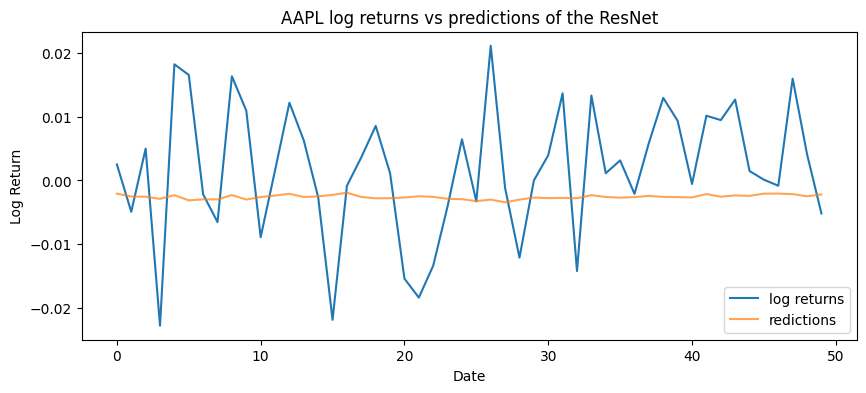

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(truths, label="log returns")
plt.plot(preds, label="redictions", alpha=0.7)
plt.title("AAPL log returns vs predictions of the ResNet")
plt.xlabel("Date")
plt.ylabel("Log Return")  
plt.legend()
plt.show()

In [3]:
df = pd.read_csv('230216_returns.csv')

In [4]:
df.head()

,Date,ADBF Index,ADCM Index,ADCT Index,ADEG Index,ADHC Index,ADII Index,ADSMI Index,AEDEUR Curncy,AEDJPY Curncy,...,WIGFOOD Index,XU100 Index,XUHIZ Index,XUMAL Index,XUSIN Index,XUTEK Index,YW1 Comdty,ZAREUR Curncy,ZARJPY Curncy,ZARUSD Curncy
0,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005267,0.017349,...,-0.018581,0.151423,0.145900,0.154006,0.136939,NaN,-0.009249,0.001884,0.024162,0.006806
1,2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002269,0.009011,...,-0.051538,-0.033120,0.009194,-0.056499,0.013088,NaN,-0.005834,0.001254,0.011796,0.003593
2,2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000758,0.010369,...,0.034560,-0.043232,0.067112,-0.079351,0.024179,NaN,NaN,-0.002505,0.010493,-0.001699
3,2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003414,0.001141,...,0.041828,-0.022407,-0.003132,-0.018369,-0.026677,NaN,-0.005869,0.006905,0.003461,0.003465
4,2000-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003781,-0.001803,...,0.030046,NaN,NaN,NaN,NaN,NaN,-0.002361,0.001870,-0.006324,-0.002060


In [5]:
df['HU1 Comdty'].describe()

count    1744.000000
mean        0.000877
std         0.028854
min        -0.224703
25%        -0.016128
50%         0.001508
75%         0.018002
max         0.215146
Name: HU1 Comdty, dtype: float64

In [6]:
df['HU1 Comdty'].isna().sum()

np.int64(4259)

In [9]:
df['HU1 Comdty'].shape

(6003,)

In [10]:
df['HU1 Comdty'].head()

0   -0.008683
1   -0.013431
2    0.004587
3   -0.026366
4    0.013011
Name: HU1 Comdty, dtype: float64

pred oos
truths

reg lin ols (pred oos, truths)

t stat - p value; avantage très rapide et donne une p value assez acceptable et facile a mettre en place pour les autres modèles 

mieux que le r2 : la p value